In [ ]:
# %load_ext autoreload
# %autoreload 2


import torch
import torchvision

import cv2
import matplotlib.pyplot as plt
import textwrap
import os

from dlrep.ImageCaptioning.data.dataload import ImageCaptionDataset, String2Int, load_meta
from dlrep.ImageCaptioning.models import ShowAttendTell
from dlrep.ImageCaptioning.utils import metrics
from dlrep.ImageCaptioning.utils.inference import load_prep_image, beam_caption
from dlrep.ImageCaptioning.utils import VizAttention
#http://proceedings.mlr.press/v37/xuc15.pdf

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

In [7]:
# fig, axes = plt.subplots(2, 4, figsize=(20,5))

# for i, ax in enumerate(axes.flat):
#     img = cv2.imread(train_paths[i])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax.imshow(img)
#     ax.set_title('\n'.join(textwrap.wrap(train_meta['labels'][i], width=25)))
#     ax.axis('off')
# fig.suptitle("**Training Examples**")
# fig.tight_layout()

In [31]:
train_meta = load_meta("./data/metadata/train_meta.json")
valid_meta = load_meta('./data/metadata/valid_meta.json')
train_paths = ['./data'+path for path in train_meta['paths']]
train_labels = train_meta['labels']
valid_paths = ['./data'+path for path in valid_meta['paths']]
valid_labels = valid_meta['labels']
Xy_valid = (valid_paths, valid_labels)

In [28]:
len(valid_meta['labels'])

643

In [32]:
remove_punct = '<>'
start_token = '<sos>'
stop_token = '<eos>'
pad_token = '<pad>'

stoi_config = String2Int(train_labels+valid_labels,
                        start_token=start_token, stop_token=stop_token, pad_token=pad_token,
                        remove_punct=remove_punct
)

vocab_size = len(stoi_config)
longest_caption = len(max([line.split() for line in train_meta['labels']], key=len))
print(f"{vocab_size = }")
print(f"{longest_caption = }")

vocab_size = 4248
longest_caption = 41


In [33]:
train_dataset = ImageCaptionDataset(X_paths=train_paths,
                                    y_labels=train_labels,
                                    string2int=stoi_config)

valid_dataset = ImageCaptionDataset(X_paths=valid_paths, 
                                    y_labels=valid_labels,
                                    string2int=stoi_config)

In [34]:
batchsize = 1
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=False, drop_last=True) #shuffle to True to reshuffle the data at every epoch

x, y, _allcaps = next(iter(train_dataloader))
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = torch.Size([1, 3, 256, 256])
y.shape = torch.Size([1, 43])


In [25]:
%autoreload 2

encoder = ShowAttendTell.Encoder(weights="random")
encoder.finetune(True)
decoder = ShowAttendTell.AttentionDecoder(dec_embed_dim=11, dec_hidden_dim=64, attention_dim=50, string2int=stoi_config)

criterion = torch.nn.CrossEntropyLoss()
enc_optim = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, encoder.parameters()),
    lr=0.01
)

dec_optim = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, decoder.parameters()),
    lr=0.01
)

In [28]:
for i in range(1):
    device = torch.device("cpu")
    # FORWARD
    encoded_imgs = encoder(x)
    logits, alphas, decode_lengths, sort_idx = decoder(encoded_imgs, y)

    # Loss
    ## sort target captions as they were sorted by the decoder
    ## ignore the first token in the caption since it is the start token, which we fed the model
    targets = y[sort_idx][:, 1:]
    ## use 'pack_padded_sequences' remove 'timesteps' which were either padded or not decoded - https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
    ## we already determined the decode lengths in the decoder^
    ## do this for the logits and targets
    logits = torch.nn.utils.rnn.pack_padded_sequence(logits, lengths=decode_lengths, batch_first=True)[0].to(device)
    targets = torch.nn.utils.rnn.pack_padded_sequence(targets, lengths=decode_lengths, batch_first=True)[0].to(device)
    ## calc loss
    loss = criterion(logits, targets)
    if i == 0: print(loss.item())

    # BACKWARD
    enc_optim.zero_grad()
    dec_optim.zero_grad()
    loss.backward()

    # Clip grads ?

    # Updated params
    enc_optim.step()
    dec_optim.step()

print(loss.item())

7.294570446014404
7.294570446014404


In [361]:
imn = 25
x, y, _ = train_dataset[imn]

# image = load_prep_image(f"./data/train_images/{imn}.jpg", transforms=encoder.transforms)
image_notransform = load_prep_image(f"./data/train_images/{imn}.jpg", transforms=None)

caption, final_seq, bleu4, alphas = beam_caption(x.unsqueeze(0), encoder, decoder, stoi_config, captions=y.unsqueeze(0), beam_size=3)
print(bleu4)

0


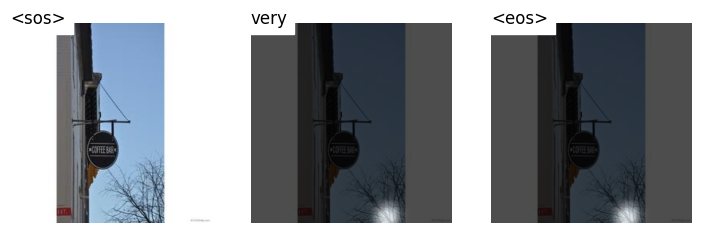

In [362]:
from utils import VizAttention

plt.figure(figsize=(15,10))
VizAttention.plot_predicted(image_notransform, final_seq, alphas, stoi_config)